# Read and plot results from the ablation experiments

# 1. Training

### 0. Libraries and dataset

In [ ]:
import matplotlib.pyplot as plt 
import model
import numpy as np
import os 
import pickle
import torch
import utils

In [ ]:
# set dataset name
dataset_name = 'facades'

### 1. Instantiate dataloaders

In [ ]:
# instantiate datasets and dataloaders
datasets = {mode: utils.ImageDataset(dataset_name = dataset_name, transform=utils.data_transforms[mode], mode = mode) for mode in ['train', 'val']}
dataloaders = {'train': utils.DataLoader(datasets['train'], batch_size=1, shuffle=True), 'val': utils.DataLoader(datasets['val'], batch_size=1, shuffle=False)}

### 2. Define the generator loss combination

In [ ]:
# different possible combinaison for the generator loss
test_modes = {'l1':[True,False,False],
              'l2':[False,True,False],
              'cGAN':[False,False,True],
              'l1_l2':[True,True,False],
              'l1_cGAN':[True,False,True],
              'l2_cGAN':[False,True,True],
              'l1_l2_cGAN':[True,True,True]}

### 3. Compute the different trainning and save the model weigths

In [ ]:
for test_mode in test_modes:
    # instantiate model every time
    p2p = model.Pix2Pix().to(utils.device)
    print(test_mode)
    bool_list = test_modes[test_mode]
    filename = 'facades_50ep_'+test_mode
    # loading the parameter in order to compute the correct generator loss combination
    l1_loss_true = bool_list[0]
    l2_loss_true = bool_list[1]
    cGAN_loss_true = bool_list[2]
    history = utils.train(model = p2p, 
                n_epochs = 50, 
                display_step = 5, 
                save_step = 50,
                dataloaders = dataloaders, 
                filename = filename,
                lr = 2e-4, 
                lbd = 200,
                loss_l1_true = l1_loss_true,
                loss_l2_true = l2_loss_true,
                loss_cGAN_true = cGAN_loss_true) 

## 2. Plots

### 1. Extracting the data of already realized training

In [24]:
test_modes = {'l1':[True,False,False],
              'l2':[False,True,False],
              'cGAN':[False,False,True],
              'l1_l2':[True,True,False],
              'l1_cGAN':[True,False,True],
              'l2_cGAN':[False,True,True],
              'l1_l2_cGAN':[True,True,True]}
data =[]
for test_mode in test_modes:
    bool_list = test_modes[test_mode]
    filename = 'facades_50ep_'+test_mode+'.pkl'
    path_file =  os.path.join(utils.history_path,filename)
    one_training_info = pickle.load(open(path_file, "rb"))
    data.append(one_training_info)
len(data)

7

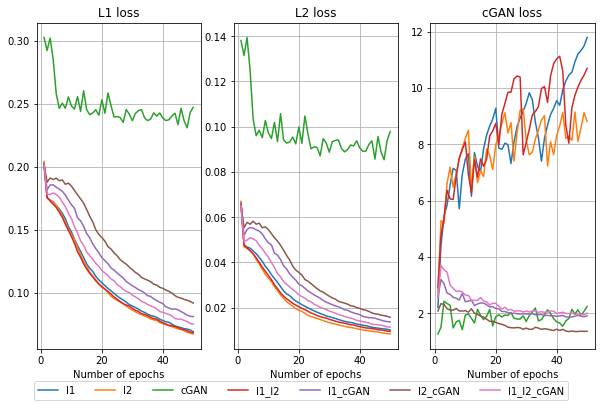

In [96]:
range_epoch = [i for i in range(1,51)]

# create figure
fig = plt.figure(figsize=(10,6))

# recover image of each batch of size 1

title = ['L1 loss', 'L2 loss', 'cGAN loss']
loss_plot = ['l1_loss','l2_loss','gan_loss']

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i],fontsize=12)
    legend = []
    for j , k in enumerate(test_modes):
        plt.plot(range_epoch,data[j][loss_plot[i]])
        legend.append(k)
    plt.grid()
    plt.xlabel('Number of epochs')
fig.legend(legend,loc='lower center',ncol=7)
plt.savefig('loss_compa.png')

### 2. Using saved model weights for different models (variation of the generator loss).

In [69]:
def plot_test_images(model_names, input, real):
    """
    Description
    -------------
    Plot input, real image and model predictions side by side
    Parameters
    -------------
    input       : input image
    real        : ground truth image
    model_names : Pix2Pix model
    """
    # create figure
    plt.figure(figsize=(6,6))

    # recover image of each batch of size 1
    display_list = [input[0], real[0]]
    title = ['Input Image', 'Ground Truth']
    for name in model_names:
        title.append('Output '+name)
        model = model.Pix2Pix().to(utils.device)
        model.load_state_dict(torch.load(os.path.join(utils.weights_path, 'test_'+name+'_ep49.pkl')))
        model.eval()
        prediction = model.generator(input.to(utils.device))
        display_list.append(prediction[0])
        
    for i in range(2+len(model_names)):
        plt.subplot(3, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot
        to_display = np.clip(display_list[i].permute(1,2,0).detach().cpu().numpy(), 0, 1)
        plt.imshow(to_display)
        plt.axis('off')
    plt.savefig(str(np.random.rand())+'.png')
    plt.show()
    

### 3. Create booth training and validation set used for vizualition purpose

In [72]:
model_names = ['l1','l2','l1_l2','cGAN','l1_cGAN','l2_cGAN','l1_l2_cGAN']

# instantiate datasets and dataloaders
dataset_name = 'facades'
datasets = {mode: utils.ImageDataset(dataset_name = dataset_name, transform=utils.data_transforms[mode], mode = mode) for mode in ['train', 'val']}
dataloaders = {'train': utils.DataLoader(datasets['train'], batch_size=1, shuffle=True), 'val': utils.DataLoader(datasets['val'], batch_size=1, shuffle=True)}

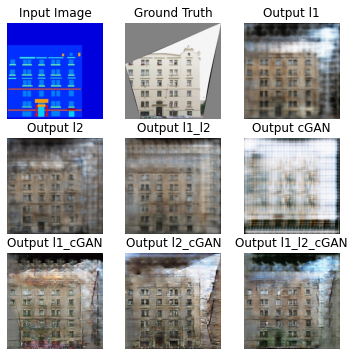

In [74]:
input,real = next(iter(dataloaders['val']))
plot_test_images(model_names, input, real)

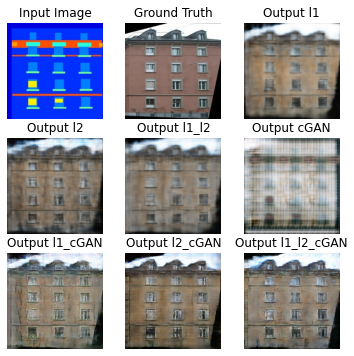

In [78]:
input,real = next(iter(dataloaders['train']))
plot_test_images(model_names, input, real)